# HW5: Dyna-Q

> - Full Name: **Ariana koocheki Dariuni**
> - Student ID: **400103624**


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-5-Questions/blob/main/RL_HW5_Dyna.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/DeepRLCourse/Homework-5-Questions/main/RL_HW5_Dyna.ipynb)

## Overview
Here the goal is to implement **Dyna-Q** for [gymnasium environments](https://gymnasium.farama.org/).
More specificly we focus on the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment and try to solve its variants (different map sizes, slippery/non-slippery, etc).

No matter which setting you choose the plotting functions and algorithms don't need any alteration!



In [1]:
# @title Imports

# Stuff you (might) need
import random
import numpy as np
import gymnasium as gym
from tqdm.notebook import trange
from heapq import heappush, heappop
from collections import defaultdict

# Stuff used for visualization
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

import base64
import imageio
import IPython

import seaborn as sns

In [2]:
# @title Visualization Functions

def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=env.metadata['render_fps']) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                action = policy(state, Q)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def plot_rewards(rewards, average_range=None, ax=None, show=False):
    if ax is None:
        fig, ax = plt.subplots()
    xs = range(1, len(rewards) + 1)
    ax.plot(xs, rewards, marker='o', linestyle='--', label='Episode Reward')
    ax.plot(xs, np.cumsum(rewards) / xs, marker='x', label='Cumulative Average')
    ax.legend()
    ax.set(xlabel='Episodes', ylabel='Total Reward', title='Episode Rewards')
    if show:
        plt.show()


def plot_heatmap(env, value, color_terminal_states=True, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        fig, ax = plt.subplots()
    dim_x, dim_y = env.unwrapped.desc.shape
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    for i in range(dim_x * dim_y):
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
            labels[i] = 'H'
        if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
            labels[i] = 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="RdYlGn", annot=labels, annot_kws={'fontsize': 16}, fmt='s')

    if color_terminal_states:
        for i in range(dim_x * dim_y):
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'H':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='black'))
            if env.unwrapped.desc[i // dim_x, i % dim_x] == b'G':
                ax.add_patch(plt.Rectangle((i % dim_x, i // dim_x), 1, 1, color='purple'))

    ax.set(title='Maximum Value per State')
    ax.set_xticks(np.linspace(0.5, dim_x-0.5, num=dim_x))
    ax.set_xticklabels(["%d" % x for x in np.arange(dim_x)])
    ax.set_yticks(np.linspace(0.5, dim_y-0.5, num=dim_y))
    ax.set_yticklabels(["%d" % y for y in np.arange(dim_y)], rotation='horizontal')
    if show:
        plt.show()
    return im


def get_color_for_value(value, vmin, vmax):
    # Normalize the value between 0 and 1
    norm_value = (value - vmin) / (vmax - vmin)
    # Get color from a colormap
    colormap = plt.cm.RdYlGn  # You can choose any other colormap
    return colormap(norm_value)


def plot_q_values_grid(q_values, env, square_size=1, color_terminal_states=True, ax=None, show=False):
    grid = env.unwrapped.desc
    rows, cols = grid.shape
    q_values = q_values.reshape(rows, cols, 4)

    if ax is None:
      fig, ax = plt.subplots()

    # Determine the range of Q-values for normalization
    vmin = np.min(q_values)
    vmax = np.max(q_values)

    # Actions correspond to directions: 0=left, 1=right, 2=down, 3=up
    actions = {0: 'left', 2: 'right', 3: 'down', 1: 'up'}

    # Loop through each position in the grid
    for i in range(rows):
        for j in range(cols):
            # Calculate the lower-left corner of the square
            x = j * square_size
            y = i * square_size

            # Define the corners of the square
            bl = (x, y)  # bottom-left
            br = (x + square_size, y)  # bottom-right
            tl = (x, y + square_size)  # top-left
            tr = (x + square_size, y + square_size)  # top-right

            # Get Q-values for current state (i, j)
            q_left = q_values[i, j, 0]
            q_up = q_values[i, j, 1]
            q_right = q_values[i, j, 2]
            q_down = q_values[i, j, 3]

            # Check if the current cell is the one to be colored black
            if color_terminal_states and grid[i, j] == b'H':
                edge_color = None
                left_color, right_color, down_color, up_color = ['black'] * 4
            elif color_terminal_states and grid[i, j] == b'G':
                edge_color = None
                left_color, right_color, down_color, up_color = ['purple'] * 4
            else:
                edge_color = 'black'
                left_color = get_color_for_value(q_left, vmin, vmax)
                right_color = get_color_for_value(q_right, vmin, vmax)
                down_color = get_color_for_value(q_down, vmin, vmax)
                up_color = get_color_for_value(q_up, vmin, vmax)

            # Draw and color the triangles based on Q-values
            triangle_left = patches.Polygon([bl, tl, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=left_color)
            triangle_right = patches.Polygon([br, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                             edgecolor=edge_color, facecolor=right_color)
            triangle_down = patches.Polygon([bl, br, (x + square_size/2, y + square_size/2)], closed=True,
                                            edgecolor=edge_color, facecolor=down_color)
            triangle_up = patches.Polygon([tl, tr, (x + square_size/2, y + square_size/2)], closed=True,
                                          edgecolor=edge_color, facecolor=up_color)

            ax.add_patch(triangle_left)
            ax.add_patch(triangle_right)
            ax.add_patch(triangle_down)
            ax.add_patch(triangle_up)

    # Set the title
    ax.set(title='Action-State Values')

    # Set the limits of the plot
    ax.set_xlim(0, cols * square_size)
    ax.set_ylim(0, rows * square_size)

    # Set aspect of the plot to be equal
    ax.set_aspect('equal')

    # Disable ticks on both axes
    ax.set_xticks([])  # Disable x ticks
    ax.set_yticks([])  # Disable y ticks

    ax.invert_yaxis()  # Optional: Invert y-axis to have (0,0) at the top-left corner
    plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='RdYlGn'), ax=ax, label='Q-value')
    if show:
        plt.show()


def plot_performance(env, value, reward_sums):
    # Create a figure
    fig = plt.figure(figsize=(16, 12), dpi=200)

    # Define a GridSpec with 2 rows and 2 columns
    gs = GridSpec(2, 2, figure=fig)

    # Plot in the first row spanning both columns
    ax1 = fig.add_subplot(gs[0, :])
    plot_rewards(reward_sums, ax=ax1)

    # Plot in the second row
    ax2 = fig.add_subplot(gs[1, 0])
    plot_q_values_grid(value, env, ax=ax2)

    ax3 = fig.add_subplot(gs[1, 1])
    plot_heatmap(env, value, ax=ax3)

    # Show the plots
    plt.show()

# Explore the Environment (5 points)

First we must create the environment.
In order to be able to render the environment we use `render_mode="rgb_array"` as the render mode.


In [3]:
slippery = True
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=slippery)

# TODO: Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Discrete(16)
Actions: Discrete(4)


Define a random policy that randomly selects an action from the action space.

In [4]:
def random_policy(*args):
    # TODO: Select a random action
    action = env.action_space.sample()
    return action

Visualize the random policy.

In [5]:
create_policy_eval_video(env, random_policy, 'random_policy', num_episodes=5)

# Policies (5 points)

First define a greedy policy that takes a state $s$ and returns the action $a$ with the highest $Q(s,a)$.

In [6]:
def greedy_policy(state: int, q_values: np.ndarray) -> int:
    # TODO: Select a greedy action
    action = np.argmax(q_values[state])
    return action

Now define a policy that selects a greedy action with probability $1-\varepsilon$ and selects a random action with probability $\varepsilon$, for given a constant $\varepsilon$.

In [7]:
def epsilon_greedy_policy(state: int, q_values: np.ndarray, epsilon: float) -> int:
    # TODO: Select an epsilon-greedy action
    action = random_policy() if np.random.rand() < epsilon else greedy_policy(state, q_values)
    return action

# Dyna-Q (25 points)

**Dyna-Q** combines model-free and model-based reinforcement learning by integrating direct learning from experience with planning from a learned model.
Unlike **Q-learning**, which only updates the action values based on real experiences, **Dyna-Q** uses a learned model of the environment to simulate additional experiences and update the action values, accelerating the learning process.

The environment we are working with is *deterministic* when `is_slippery=False`.
For this reason we use also use a *deterministic* model for the environment.
In order to see how **Dyna-Q** gets implemented for *stochastic* environmnets, check out the workshop!

## Planning (10 points)

In addition to this update from real experiences, **Dyna-Q** updates the action values using simulated experiences:


$$Q(s, a) \leftarrow Q(s, a) + \alpha \left(\hat{r} + \gamma \max_{a'} Q(\hat{s}, a') - Q(s, a)\right)$$


Complete the `q_planning` function to perform `n` steps of planning.

In [8]:
def q_planning(model: dict, q: np.ndarray, alpha: float, gamma: float, n: int) -> np.ndarray:

    # TODO: Perform n steps of planning
    for _ in range(n):
        # TODO: Randomly sample a known state-action pair
        state, action = random.choice(list(model.keys()))

        # TODO: Get the predicted reward and next_state from the model
        next_state, reward = model[(state, action)]

        # TODO: Update Q-value using the deterministic transition
        q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

    return q

## Learning (15 points)

For `n_episodes`, take ɛ-greedy actions based on the Q-values and at each step update them:

$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t)\right)$$

After each step you must also update the *deterministic* model and call `q_planning` to perform the planning steps.

In [9]:
def dyna_q(n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
           gamma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Dyna-Q algorithm for deterministic environments."""

    reward_sums = np.zeros(n_episodes)
    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Dyna-Q model for deterministic environments
    model = defaultdict(dict)

    for episode_i in (pbar := trange(n_episodes, leave=False)):
        state, info = env.reset()
        reward_sum, done = 0, False

        while not done:
            # TODO: Take ɛ-greedy action
            action = epsilon_greedy_policy(state, q, epsilon)
            # TODO: Q-learning update
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated


            q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

            # TODO: Update deterministic model
            model[(state, action)] = (next_state, reward)

            # TODO: Planning step(s)
            q = q_planning(model, q, alpha, gamma, n)

            # TODO: Move to next state
            state = next_state

            # TODO: Update reward sum
            reward_sum += reward

        pbar.set_description(f'Episode Reward {int(reward_sum)}')
        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Experiments (15 points)

Here you can run a bunch of experiments.
You can use the given template for your experiments.

If you have trouble getting started, work with a smaller map instead by setting `map_name="4x4"` but keep in mind the ultimate goal of this assignment is solving the larger `8x8` grid.
Using a simpler environment could help you better understand the limitations and motivate you to come up with solutions.

After playing with the hyperparameters you should answer the following questions:

*   How does increasing the number of planning steps affect the overall learning process?
*   What would happen if we set `is_slippery=True` assuming we **didn't** change the *deterministic* nature of our algorithm?
*   Does planning even help for this specific environment? How so? (Hint: analyze the reward signal)
*   Assuming it takes $N_1$ episodes to reach the goal for the first time, and from then it takes $N_2$ episodes to reach the goal for the second time, explain how the number of planning steps `n` affects $N_1$ and $N_2$.

`Your Answers:`



  0%|          | 0/12000 [00:00<?, ?it/s]

<ipython-input-2-98724c2daf64>:79: RuntimeWarning: invalid value encountered in scalar divide
  norm_value = (value - vmin) / (vmax - vmin)


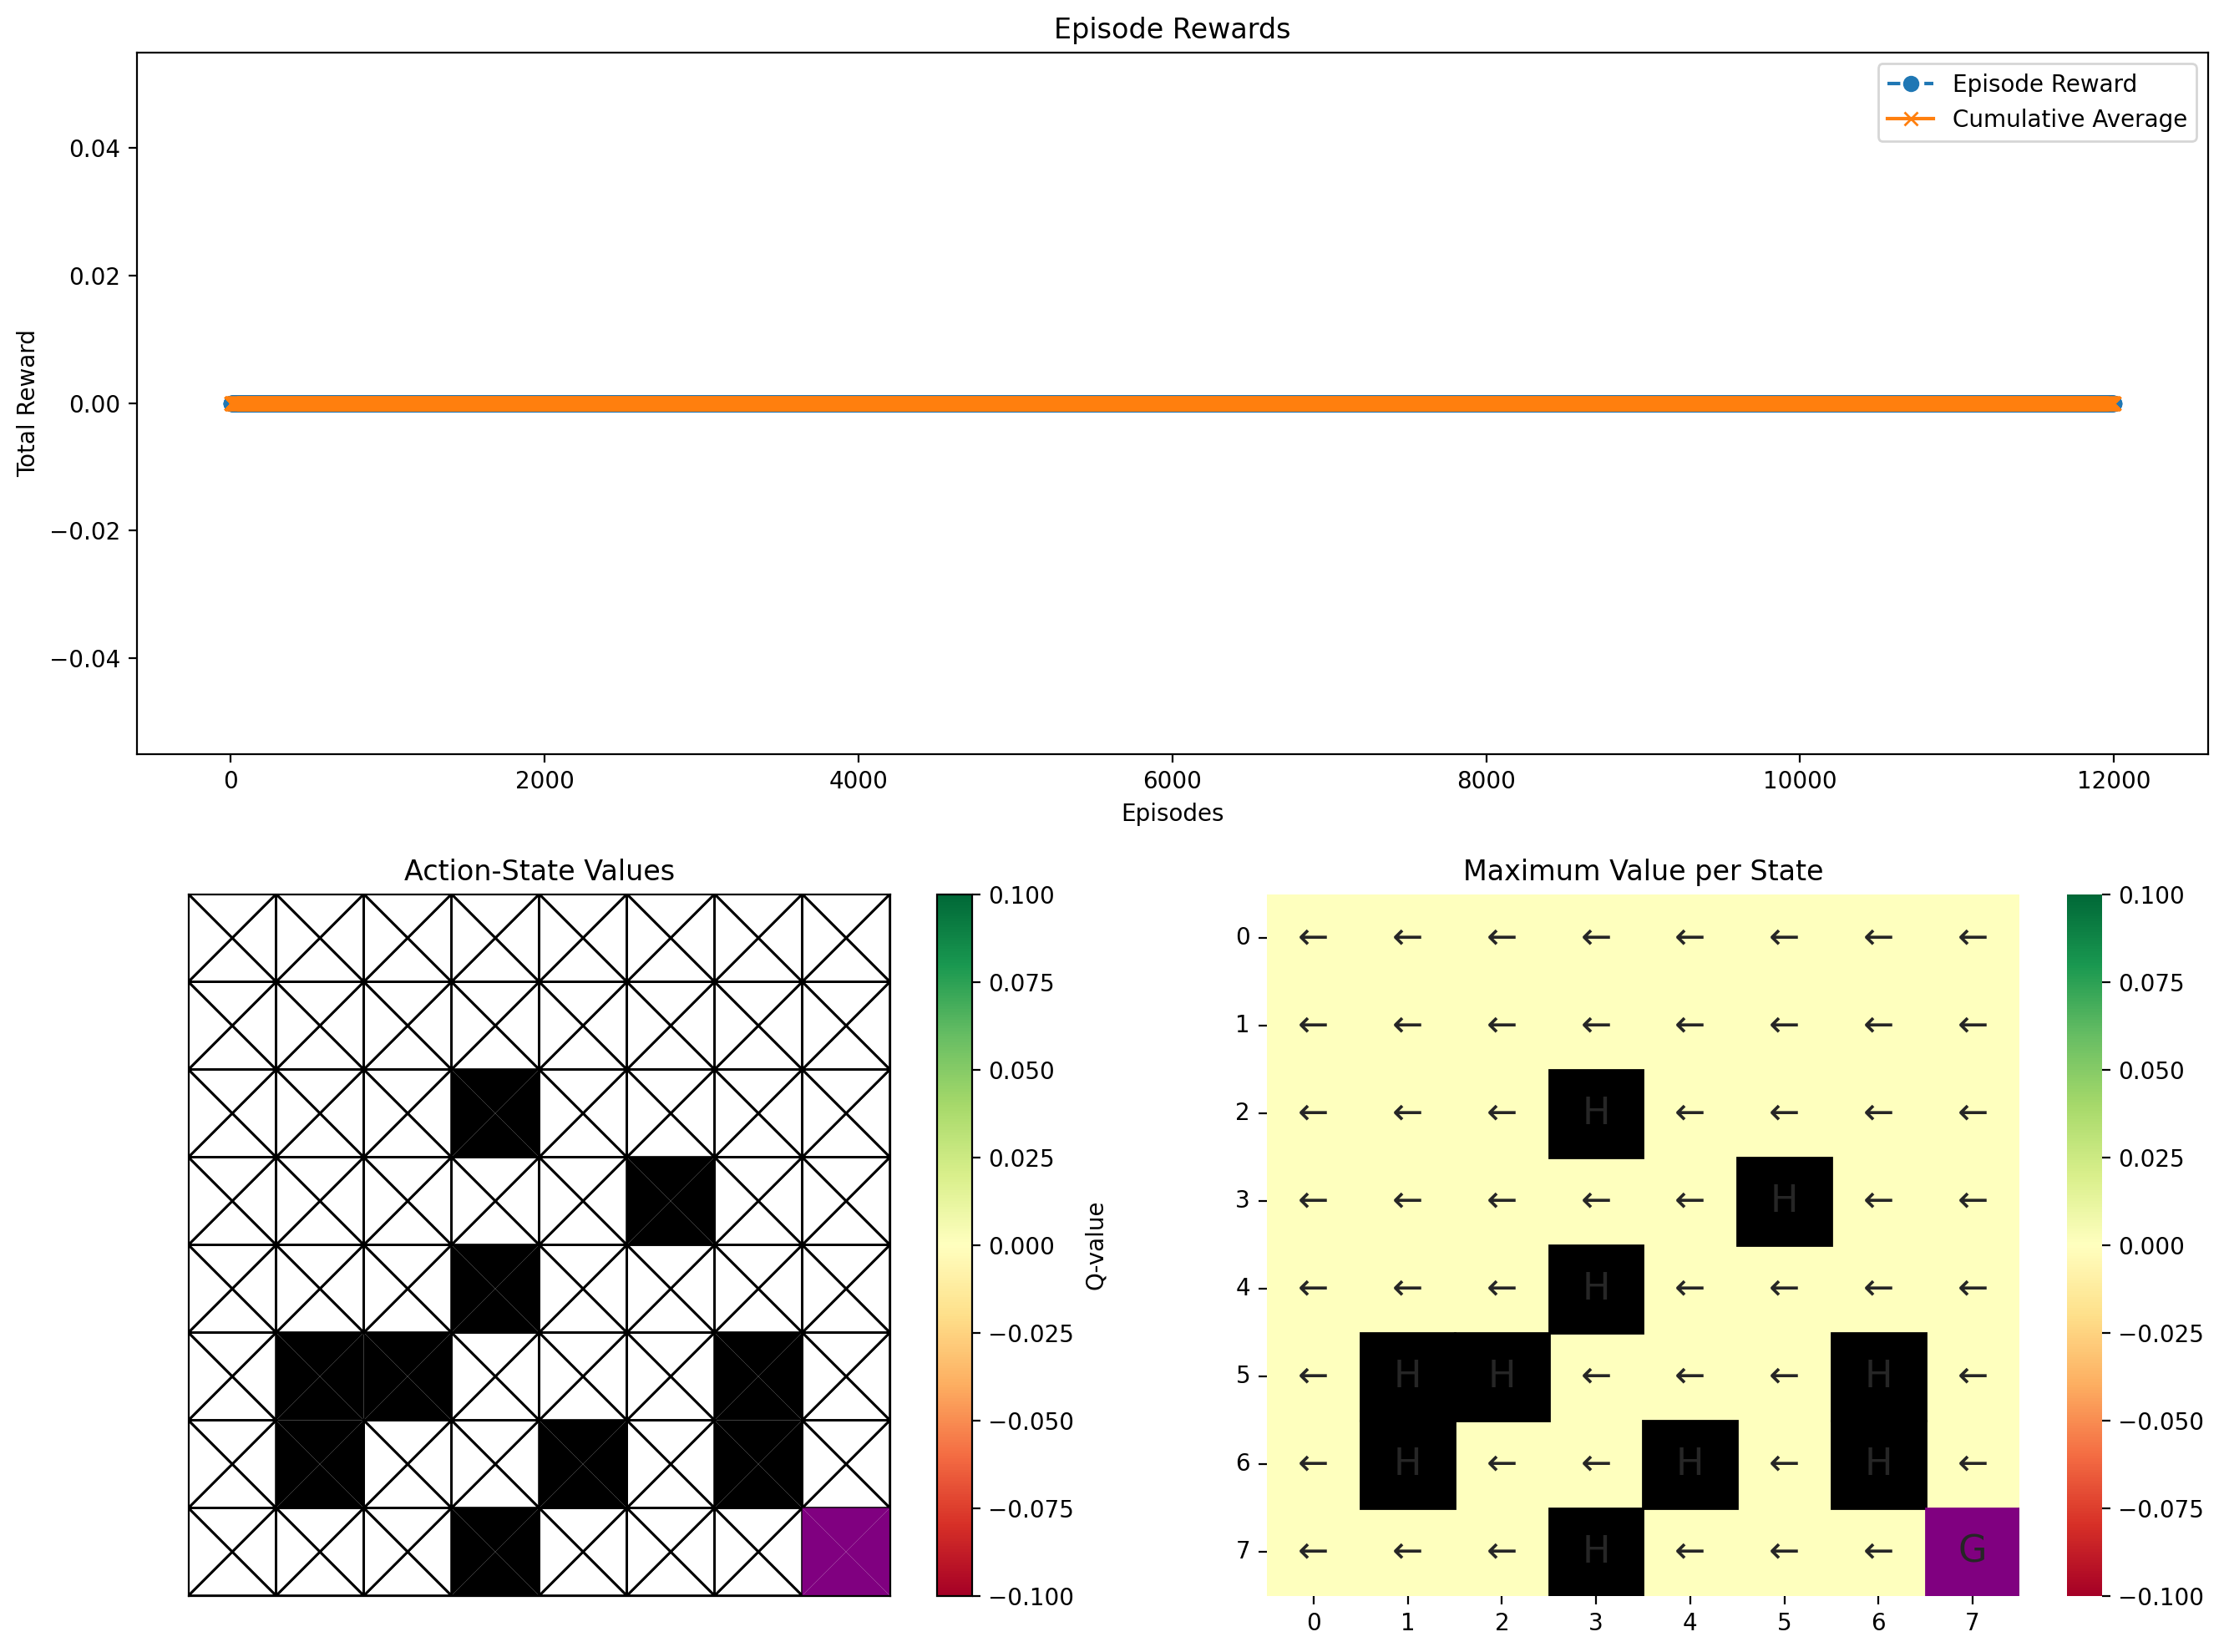

In [10]:
  # set for reproducibility
  np.random.seed(2025)

  # parameters needed by our policy and learning rule
  params = {'epsilon': 0.4,    # epsilon-greedy policy
            'alpha': 0.2,      # learning rate
            'gamma': 0.99,      # temporal discount factor
            'n': 10,          # number of planning steps
  }

  # episodes/trials
  n_episodes = 12000

  # environment initialization
  env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)

  # Solve Frozen Lake using Dyna-Q
  value_dyna_q, reward_sums_dyna_q = dyna_q(n_episodes, env, **params)

  # Plot the results
  plot_performance(env, value_dyna_q, reward_sums_dyna_q)

# Are you having troubles? (15 points)




Here are a number of options you can explore to see better results:

1.   Introduce a baseline for Q-values to speed up convergence during initialization.
2.   Change the value of $\varepsilon$ as a function of episode progression (or something else) for better exploration strategies.
3.   Replace the $\varepsilon$-greedy policy with a different policy that is better suited for this environment.
4.   Change the number of planning steps as a function of episode progression (or something else) for more efficient planning.

In the last two sections of this assignment, we examine how **Reward Shaping** and **Prioritized Sweeping** can yield better results.
Other than these two methods, you are more than welcome to introduce any other method to improve your results.

You can choose any or none of these methods at your discretion.
The only important detail is to be able to solve the environments.
You **MUST** justify each method and how it helps with issues you were facing before.

`Your Answer:`

In [ ]:
env.reset()

0

In [12]:
# TODO: Don't overwrite your previous experiments!
'''
Please leave a new code cell for each new experiment.
In a markdown cell, explain the improvements seen and justify them.
'''






'\nPlease leave a new code cell for each new experiment.\nIn a markdown cell, explain the improvements seen and justify them.\n'

# Reward Shaping (10 points)

As you know, [Reward Function Design is Difficult](https://www.alexirpan.com/2018/02/14/rl-hard.html#reward-function-design-is-difficult).
However there a few main principles than can help speed up *Temporal-Difference Learning*.
Here we ask you to modify the reward function to achieve better results.

In [13]:
from gymnasium.envs.toy_text import FrozenLakeEnv

class CustomFrozenLakeEnv(FrozenLakeEnv):
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)
        # Modify the reward calculation
        reward = self.custom_reward_function(obs, reward, terminated)
        return obs, reward, terminated, truncated, info

    def custom_reward_function(self, observation, reward, done):
        # TODO: Define your custom reward logic here
        if done and reward == 1:  # Reached goal
            return 10  # Increase reward for success
        if done:  # Fell into a hole
            return -5  # Strong penalty for failing
        return -0.05


Experiment with the new environment and improved reward function.

Explanin how your modifications improved the results.

`Your Answer:`

  0%|          | 0/7000 [00:00<?, ?it/s]

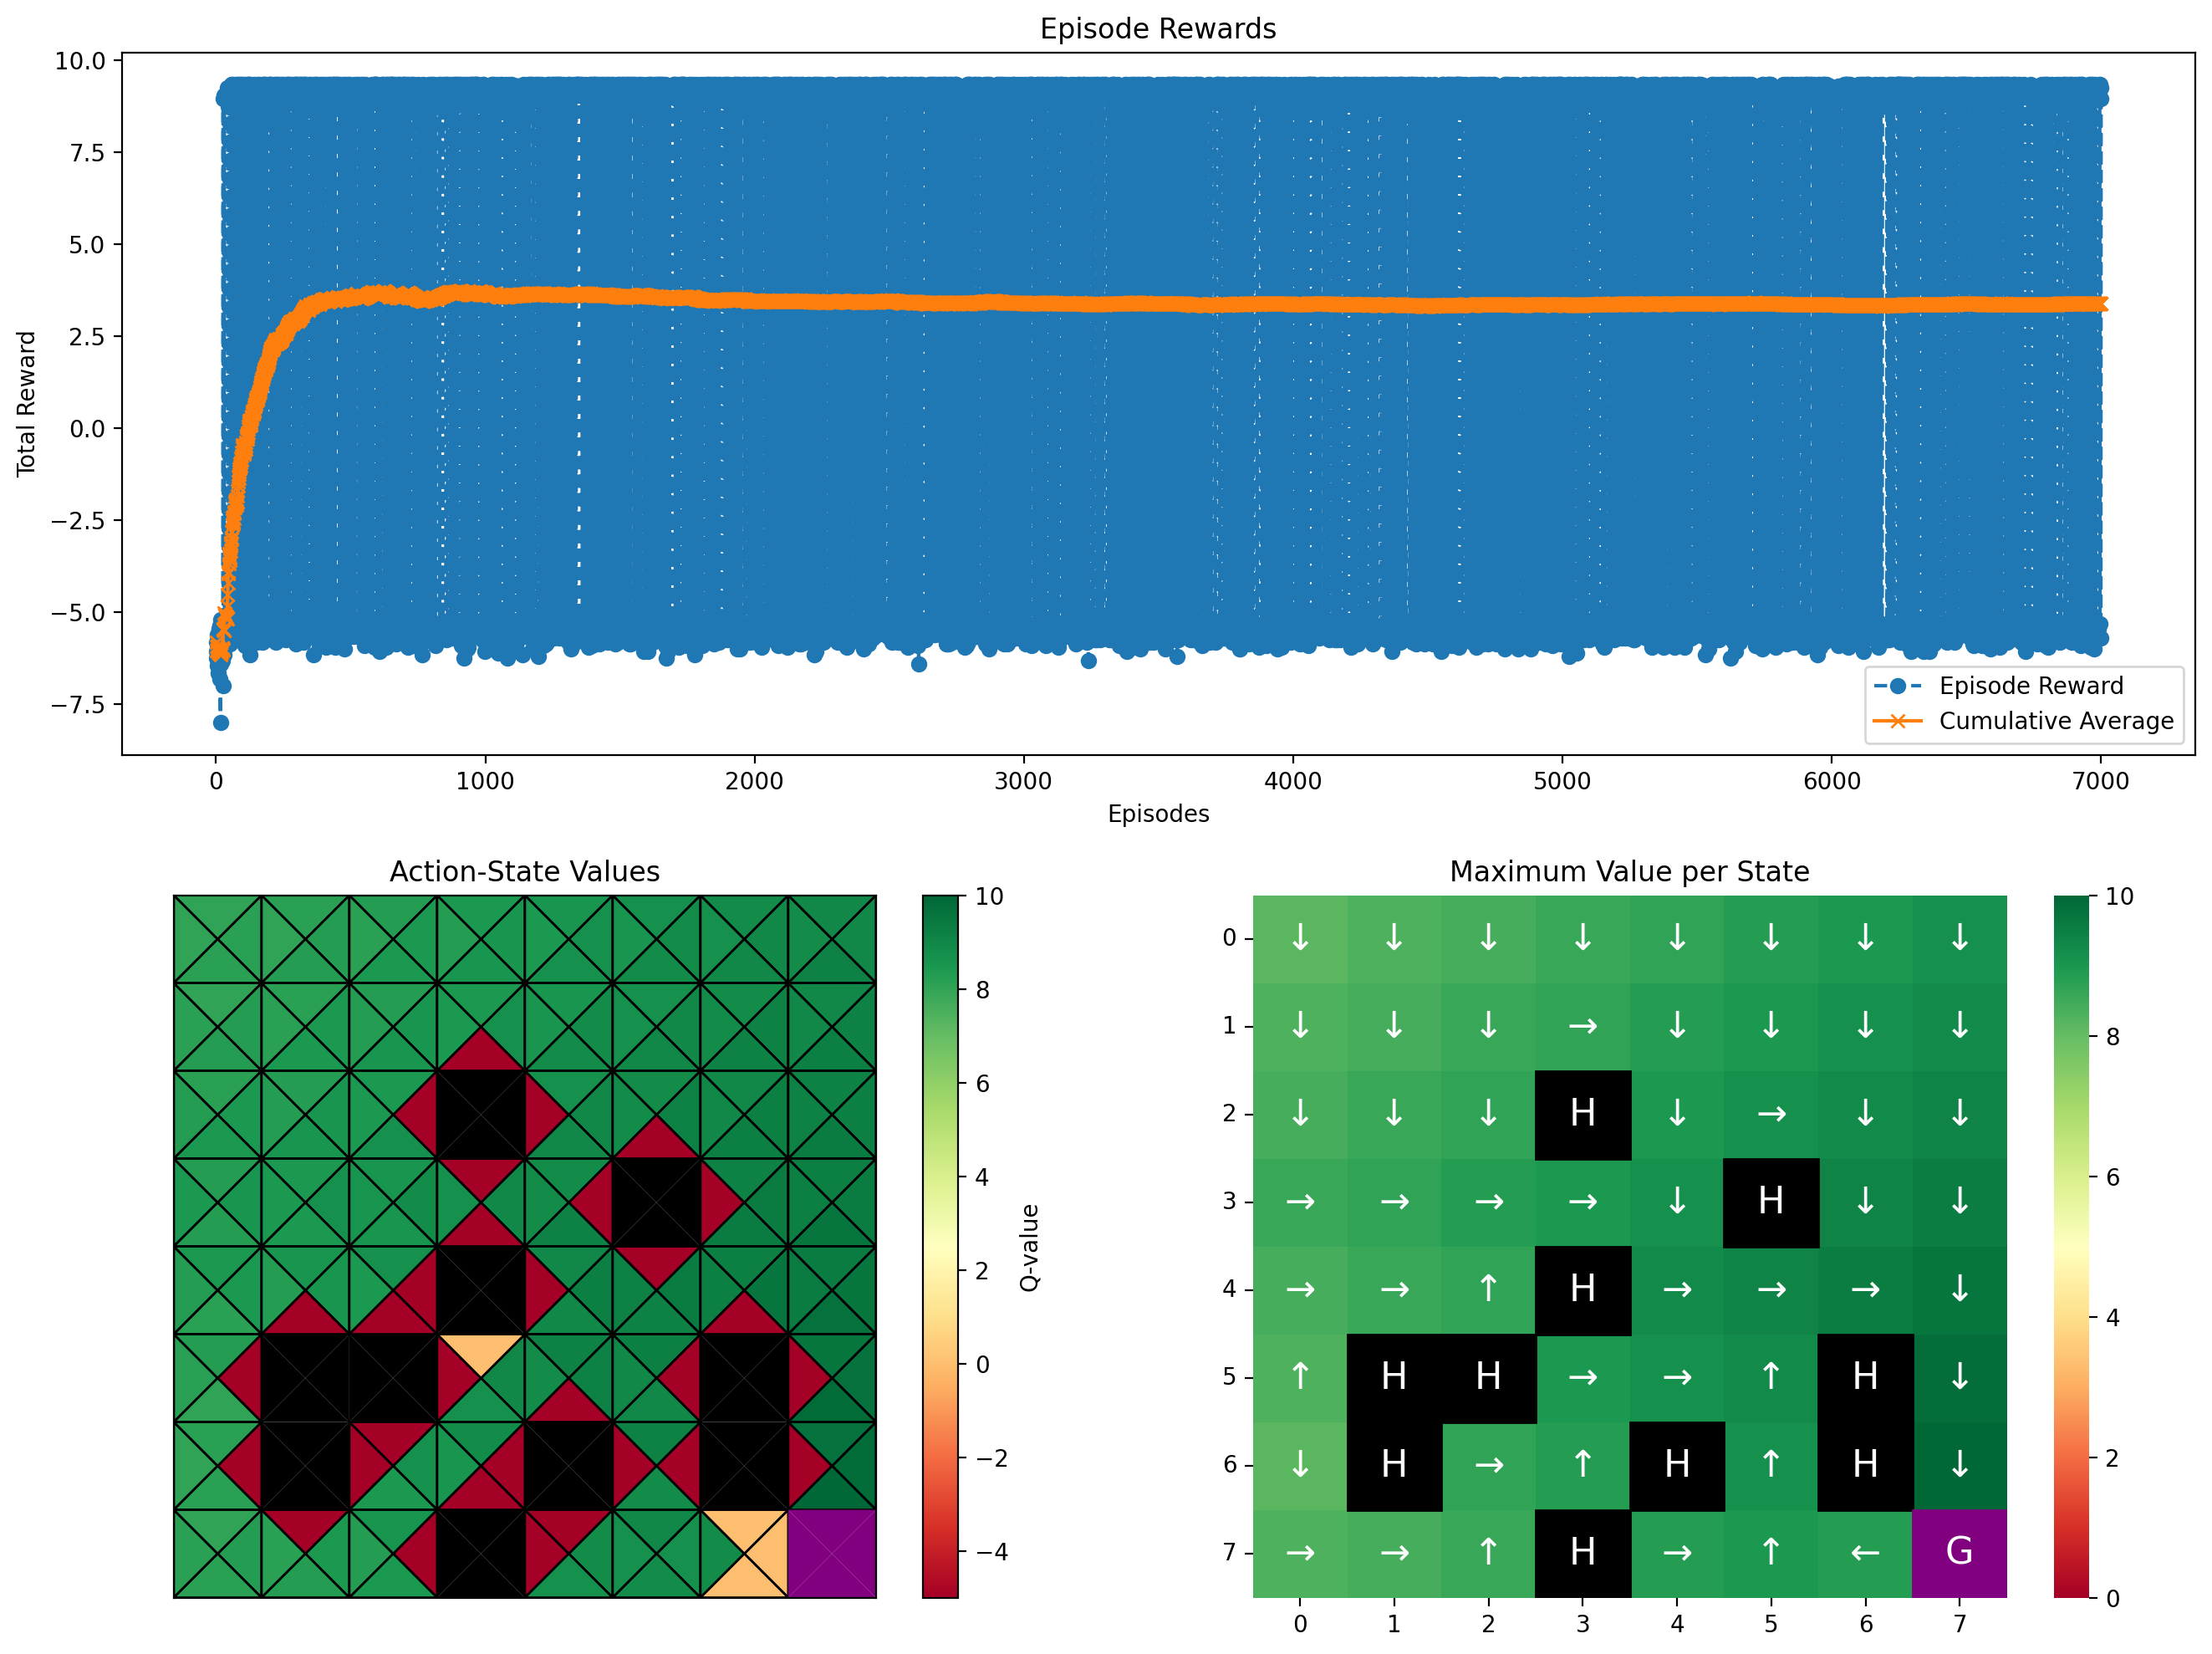

In [14]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'epsilon': 0.2,   # epsilon-greedy policy
          'alpha': 0.1,     # learning rate
          'gamma': 0.99,     # temporal discount factor
          'n': 10,         # number of planning steps
}

# episodes/trials
n_episodes = 7000

# environment initialization
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=False)

# Solve Frozen Lake using Dyna-Q
value_dyna_q, reward_sums_dyna_q = dyna_q(n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)

# Prioritized Sweeping (20 points)

In the Dyna agents presented in the preceding sections, simulated transitions are started in state-action pairs selected uniformly at random from all previously experienced pairs.
But a uniform selection is usually not the best; planning can be much more efficient if simulated transitions and updates are focused on particular state-action pairs.

## Priority Planning (10 points)

The `q_planning_priority` function performs planning updates using **Prioritized Sweeping** by first checking if the priority queue is empty and then iterating for a specified number of planning steps.
It pops the state-action pair with the highest priority from the queue, retrieves the deterministic transition, and updates the Q-value using the temporal-difference (TD) error.
Next, it updates priorities for predecessor state-action pairs that transition to the current state, calculating their TD errors and pushing significant ones back into the priority queue.

In [15]:
def q_planning_priority(model: dict, q: np.ndarray, priorities: list, alpha: float, gamma: float, n: int) -> np.ndarray:
    """Performs planning updates using Prioritized Sweeping."""

    # TODO: Perform n steps of planning
    for _ in range(n):
        if not priorities:
            break

        # TODO: Sample the state-action pair with the highest priority
        _, (state, action) = heappop(priorities)

        # TODO: Retrieve deterministic transition
        if (state, action) not in model:
            continue
        next_state, reward = model[(state, action)]

        # TODO: Update Q-value using the deterministic transition
        td_target = reward + gamma * np.max(q[next_state])
        td_error = td_target - q[state, action]
        q[state, action] += alpha * td_error

        # TODO: Update priorities for predecessors
        for (prev_state, prev_action), (s_next, _) in model.items():
            if s_next == state:  # If the previous state leads to the current one
                priority = abs(td_error)  # Higher error → higher priority
                if priority > 1e-6:  # Avoid unnecessary small updates
                    heappush(priorities, (-priority, (prev_state, prev_action)))

    return q


## Learning with Prioritized Sweeping (10 points)

Similar to the original `dyna_q` function, you need to implement the `dyna_q_priority`.
This time you must also store priorities and use a threshold parameter $\theta$ that determines whether a state-action pair should be added to the priority queue based on the magnitude of the temporal-difference (TD) error.

Specifically, $\theta$ is used to filter out small TD errors that are considered insignificant.
When the absolute value of the TD error for a state-action pair is greater than $\theta$, the pair is added to the priority queue.
This ensures that only state-action pairs with significant TD errors are prioritized for planning updates.

In [16]:
def dyna_q_priority(n_episodes: int, env: gym.Env, max_epsilon: float, alpha: float,
                    gamma: float, n: int, theta: float) -> tuple[np.ndarray, np.ndarray]:
    """Dyna-Q with Prioritized Sweeping algorithm for deterministic environments."""

    reward_sums = np.zeros(n_episodes)
    epsilon = max_epsilon
    q = np.zeros((env.observation_space.n, env.action_space.n))

    # Dyna-Q model for deterministic environments
    model = defaultdict(dict)

    # Priority queue for prioritized sweeping
    priorities = []

    for episode_i in (pbar := trange(n_episodes, leave=False)):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # TODO: Take ɛ-greedy action
            action = epsilon_greedy_policy(state, q, epsilon)
            next_state, reward, terminal, truncated, _ = env.step(action)
            terminal = terminal or truncated

            # TODO: Q-learning update
            td_target = reward + gamma * np.max(q[next_state])
            td_error = td_target - q[state, action]
            q[state, action] += alpha * td_error

            # TODO: Update deterministic model
            model[(state, action)] = (next_state, reward)

            # TODO: Update priority queue if the TD error is significant
            if abs(td_error) > theta:
                heappush(priorities, (-abs(td_error), (state, action)))

            # TODO: Planning step with prioritized sweeping
            q = q_planning_priority(model, q, priorities, alpha, gamma, n)

            # TODO: Move to next state
            state = next_state

            # TODO: Update reward sum
            reward_sum += reward


        epsilon = max(0.05, max_epsilon - episode_i / (n_episodes * 0.5))
        pbar.set_description(f'Episode Reward {int(reward_sum)}')
        reward_sums[episode_i] = reward_sum

    return q, reward_sums

# Final Experiments (5 points)

We're almost done!
All that remains is for you to test **Prioritized Sweeping**.

  0%|          | 0/5000 [00:00<?, ?it/s]

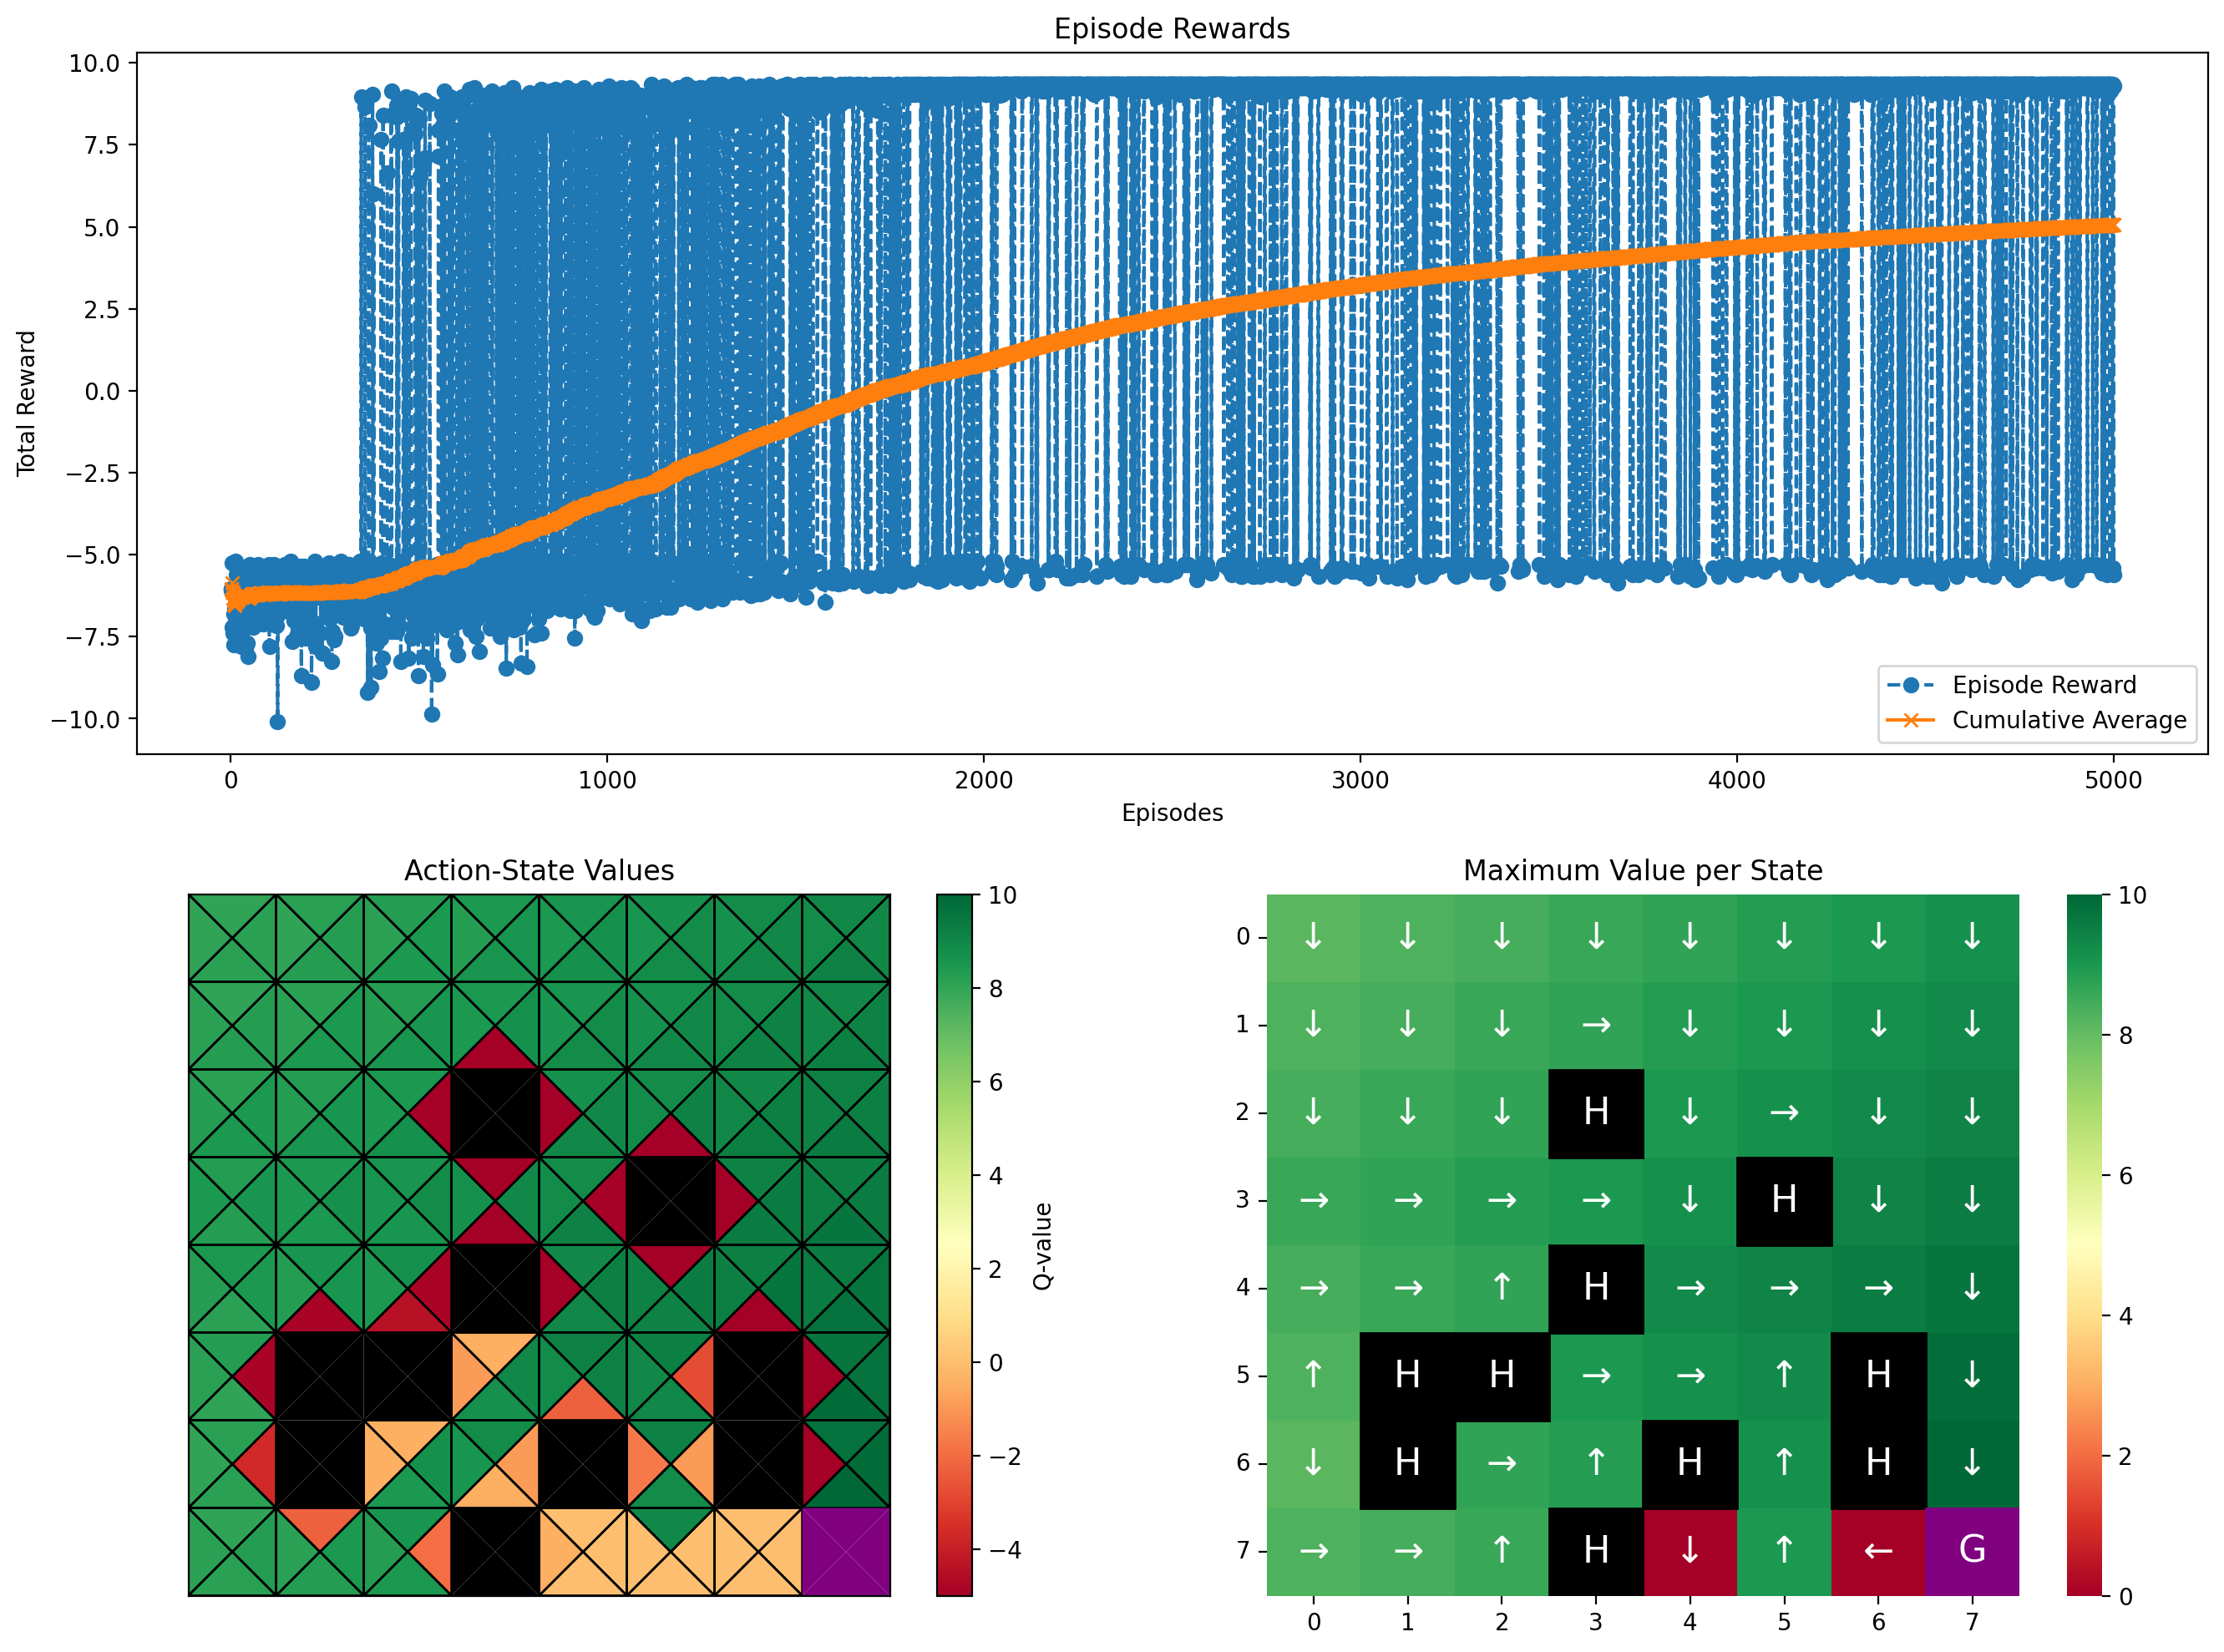

In [17]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'max_epsilon': 0.9,   # epsilon-greedy policy
          'alpha': 0.05,     # learning rate
          'gamma': 0.99,     # temporal discount factor
          'n': 10,         # number of planning steps
          'theta': 0.05      # prioritization threshold
}

# episodes/trials
n_episodes = 5000

# environment initialization
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=False)

# Solve Frozen Lake using Dyna-Q with Prioritized Sweeping
value_dyna_q, reward_sums_dyna_q = dyna_q_priority(n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)

Visualize the learned policy.

In [18]:
env = CustomFrozenLakeEnv(map_name="8x8", render_mode="rgb_array", is_slippery=False)
create_policy_eval_video(env, greedy_policy, 'DynaQ', Q=value_dyna_q)

Explain how these last improvements helped.

`Your Answer:`

# Extra (10 points)

If this assignment was too easy for you, feel free to implement *Prioritized Sweeping* for stochastic environments and try to learn the `8x8` Frozen Lake with `is_slippery=True`.
Use everything you've learned to achieve better results!

In [19]:
# @title 🧊 Happy Coding 🤖
def q_planning(model: dict, q: np.ndarray, alpha: float, gamma: float, n: int) -> np.ndarray:
    # TODO: Perform n steps of planning
    for _ in range(n):
        # TODO: Randomly sample a known state-action pair
        state, action = random.choice(list(model.keys()))

        # TODO: Get the predicted reward and next_state from the model

        next_states, reward = model[(state, action)]

        next_state = random.choices(list(next_states.keys()), weights=list(next_states.values()), k=1)[0]

        # TODO: Update Q-value using the deterministic transition
        q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])

    return q


def dyna_q(q, n_episodes: int, env: gym.Env, epsilon: float, alpha: float,
           gamma: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Dyna-Q algorithm for deterministic environments."""

    reward_sums = np.zeros(n_episodes)

    # Dyna-Q model for deterministic environments
    model = {}

    for episode_i in (pbar := trange(n_episodes, leave=False)):
    # for episode_i in range(n_episodes):
        state, info = env.reset()
        reward_sum, terminal = 0, False

        while not terminal:
            # TODO: Take ɛ-greedy action
            action = epsilon_greedy_policy(state, q, epsilon)

            # TODO: Execute action and observe reward & next state
            next_state, reward, terminal, truncated, _ = env.step(action)
            terminal = terminal or truncated

            # TODO: Q-learning update
            q[state, action] += alpha * (reward + gamma * np.max(q[next_state]) - q[state, action])
            # TODO: Update deterministic model
            if (state, action) not in model:
                model[(state, action)] = [{}, 0]
            if next_state not in model[(state, action)][0]:
                model[(state, action)][0][next_state] = 0

            model[(state, action)][1] = (model[(state, action)][1] * sum(model[(state, action)][0].values()) + reward) / (sum(model[(state, action)][0].values()) + 1)
            model[(state, action)][0][next_state] += 1

            # TODO: Planning step(s)
            q = q_planning(model, q, alpha, gamma, n)

            # TODO: Move to next state
            state = next_state

            # TODO: Update reward sum
            reward_sum += reward

        pbar.set_description(f'Episode Reward {int(reward_sum)}')
        reward_sums[episode_i] = reward_sum

    return q, reward_sums


  0%|          | 0/80000 [00:00<?, ?it/s]

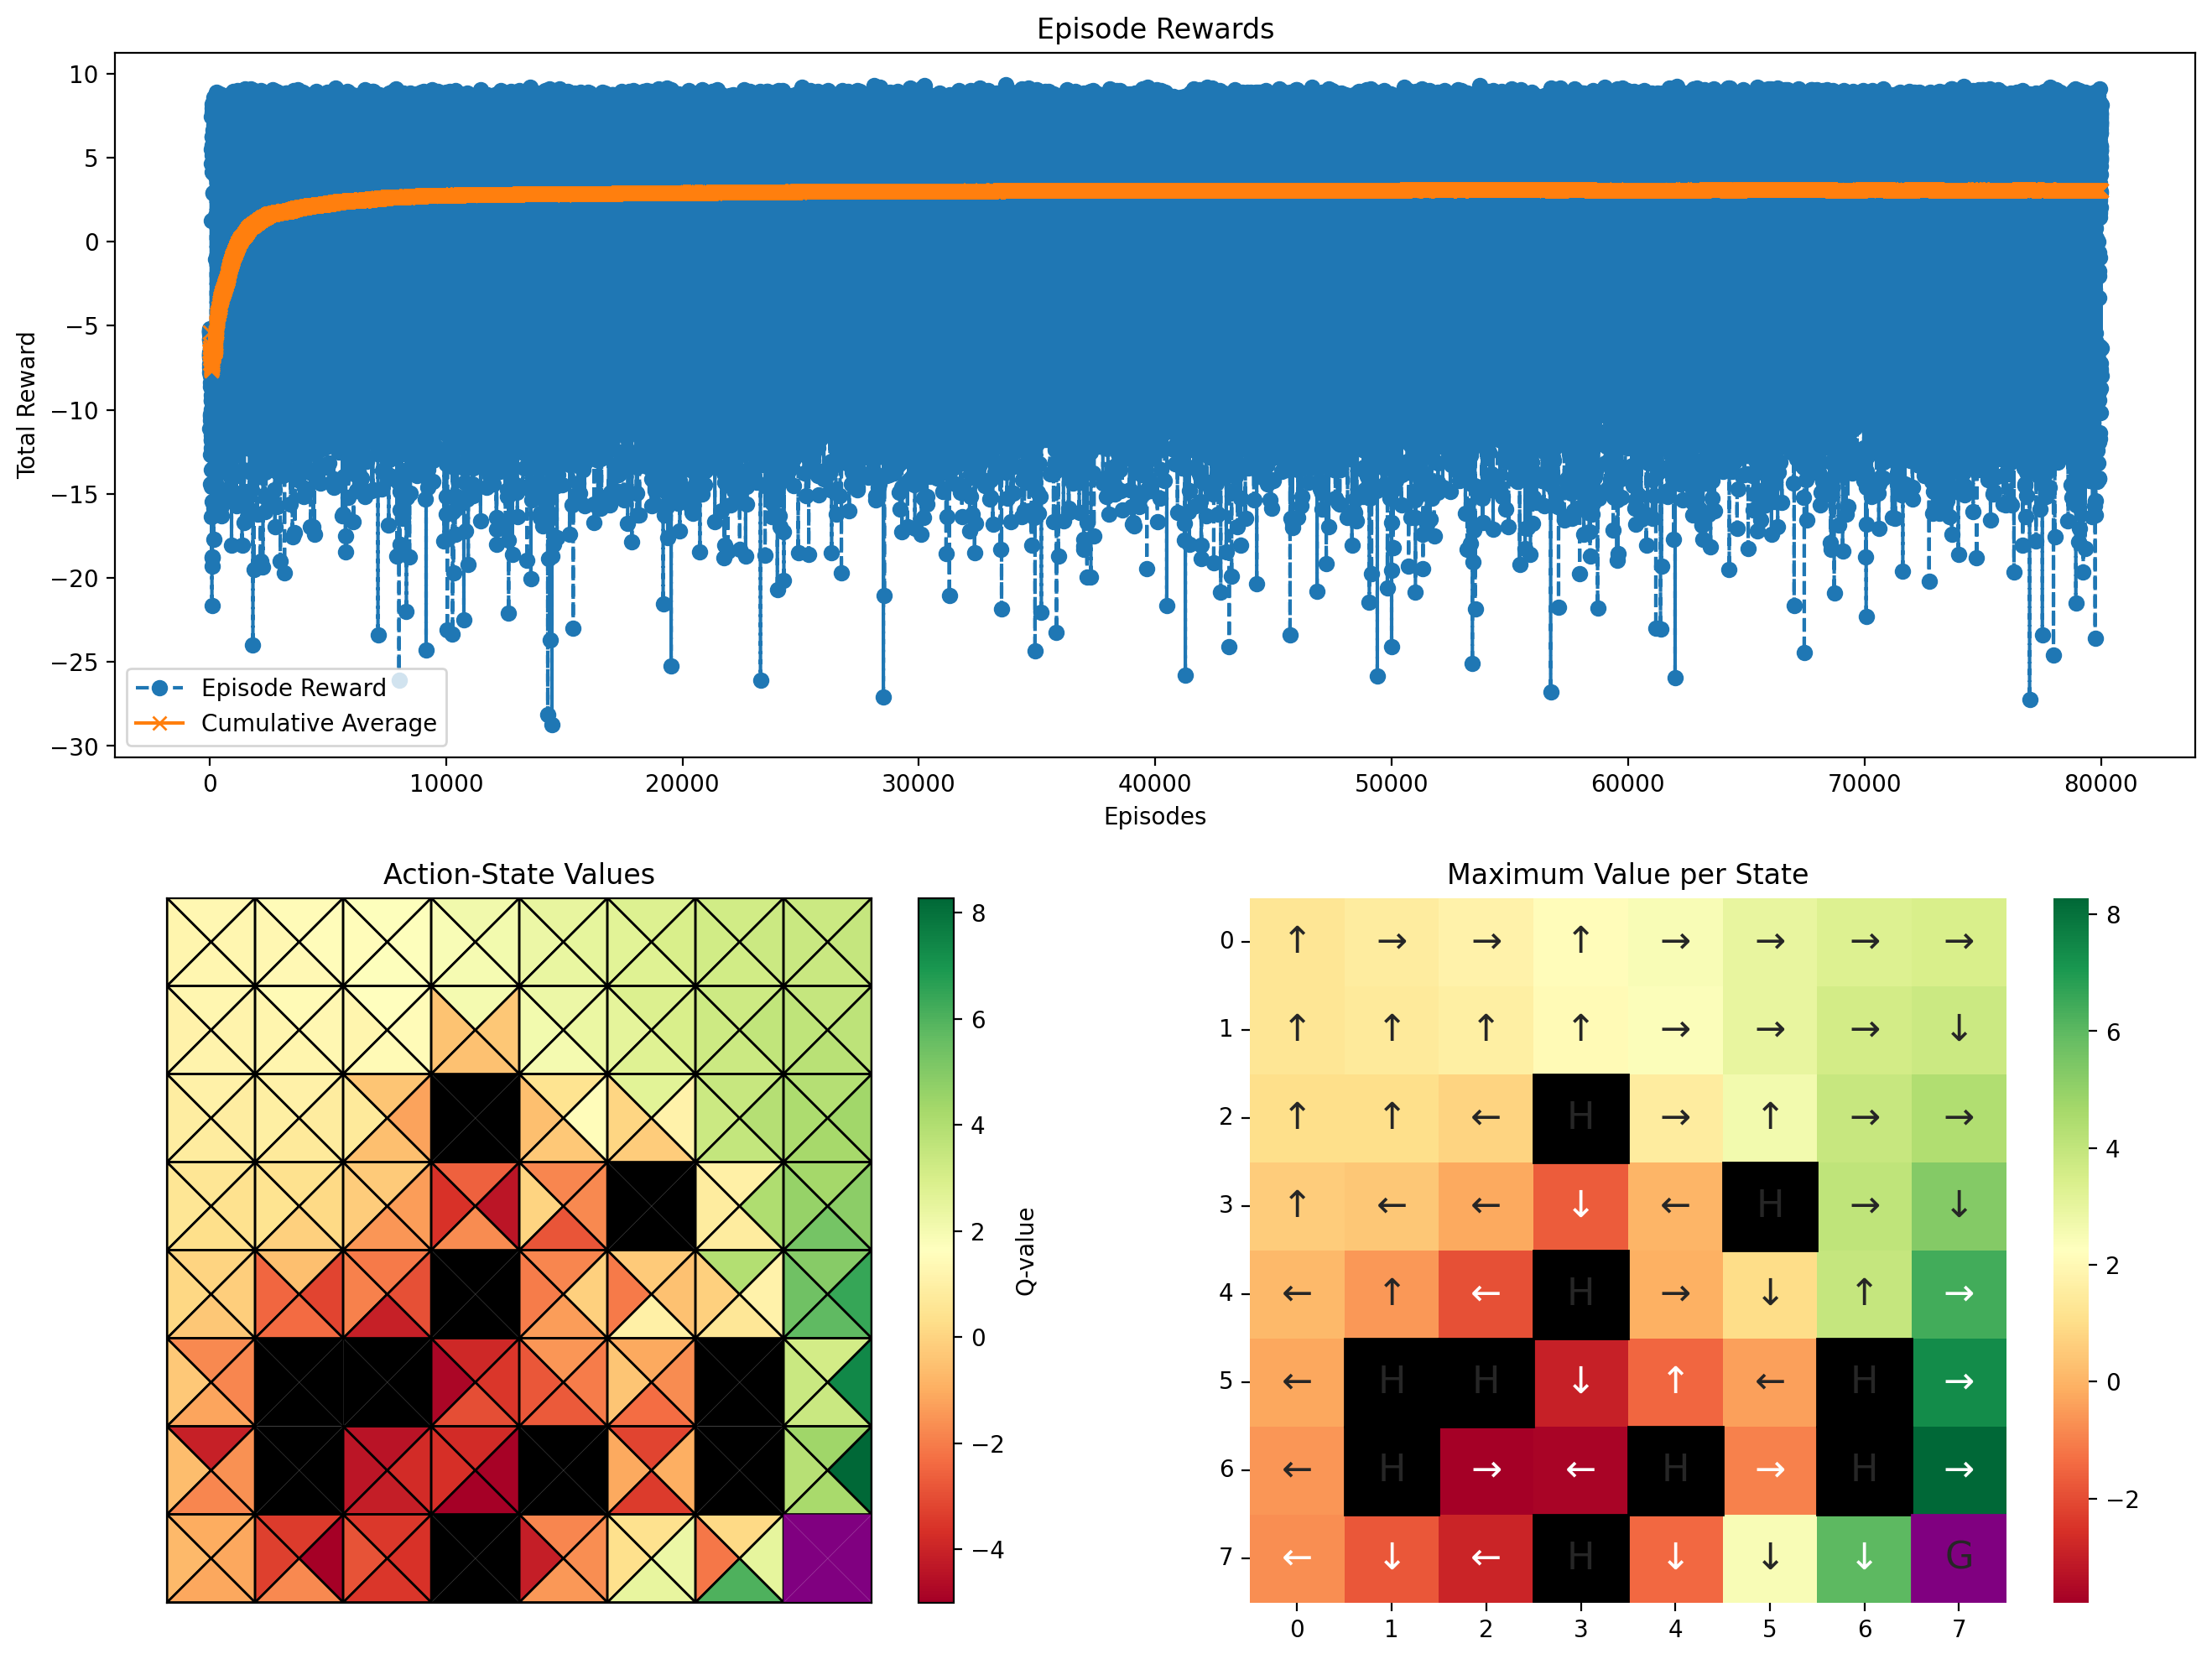

In [22]:
# set for reproducibility
np.random.seed(2025)

# parameters needed by our policy and learning rule
params = {'epsilon': 0.01,   # epsilon-greedy policy
          'alpha': 0.04,     # learning rate
          'gamma': 0.99,     # temporal discount factor
          'n': 10,         # number of planning steps
}

# episodes/trials
n_episodes = 80000

# environment initialization
env = CustomFrozenLakeEnv(map_name="8x8", is_slippery=True)

# Solve Frozen Lake using Dyna-Q
q_decay = np.zeros((env.observation_space.n, env.action_space.n))
value_dyna_q, reward_sums_dyna_q = dyna_q(q_decay, n_episodes, env, **params)

# Plot the results
plot_performance(env, value_dyna_q, reward_sums_dyna_q)

In [23]:
env = CustomFrozenLakeEnv(map_name="8x8", render_mode="rgb_array", is_slippery=True)
create_policy_eval_video(env, greedy_policy, 'DynaQ', Q=value_dyna_q)